In [1]:
import sys
import os
import glob
import json
import pickle
import cv2
import numpy as np

sys.path.append("..")
from mapper.common import Capture
from mapper.geometry import gps_to_ltp
import matplotlib.pyplot as plt

### Load GPS trajectory and convert from WGS-84 to ECEF

In [2]:
gps_file = "../data_processing/splitted/gps/gps.json"
gps_ = json.load(open(gps_file, "r"))
gps = np.zeros((len(gps_), 3))
gps[:, 0:2] = np.array(gps_)
gps, _ = gps_to_ltp(gps)

Origin of local tangent plane: lat: 49.32741555555556 deg -- long: 10.519741944444446 deg -- height: 0.0 m


### Linearly interpolate GPS trajectory

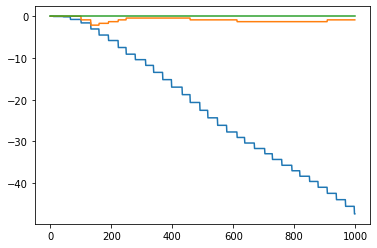

In [3]:
plt.plot(gps[:1000])

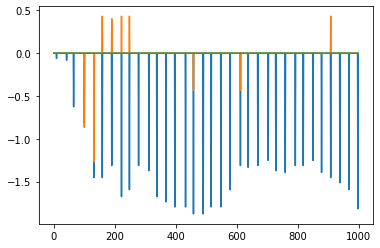

In [4]:
plt.plot(np.diff(gps[:1000, :], axis=0))

In [5]:
def interpolate_gps(gps):
    """Interpolates a piecewise constant gps signal with piecewise
    linear segments.
    
    This is needed because the GPS position acquiredby our drone is
    constant for several frames and then jumps abruptly. This 
    function smooths out the abrupt changes by linearly interpolating
    positions between the jumps.
    """
    
    # compute differences at steps, i.e. at the points where the GPS signal updates
    diffs = np.diff(gps, axis=0)
    
    # find indices where jumps occur
    update_idxs = np.where(np.abs(diffs[:, 0]) > 0)[0]
    update_idxs += 1
    update_idxs = np.insert(update_idxs, 0, 0)
    update_idxs = np.insert(update_idxs, len(update_idxs), len(gps)-1)
    
    # compute position incrementals to smoothen out jumps
    gps_diffs = []
    for i, (last_update_idx, update_idx) in enumerate(zip(update_idxs, update_idxs[1:])):       
        gps_diff = gps[update_idx] - gps[last_update_idx]
        n_steps = update_idx - last_update_idx
        for j in range(n_steps):
            gps_diffs.append(j*(gps_diff / n_steps))
    gps_diffs = np.array(gps_diffs)

    return gps[:-1, :] + gps_diffs

gps_interp = interpolate_gps(gps)

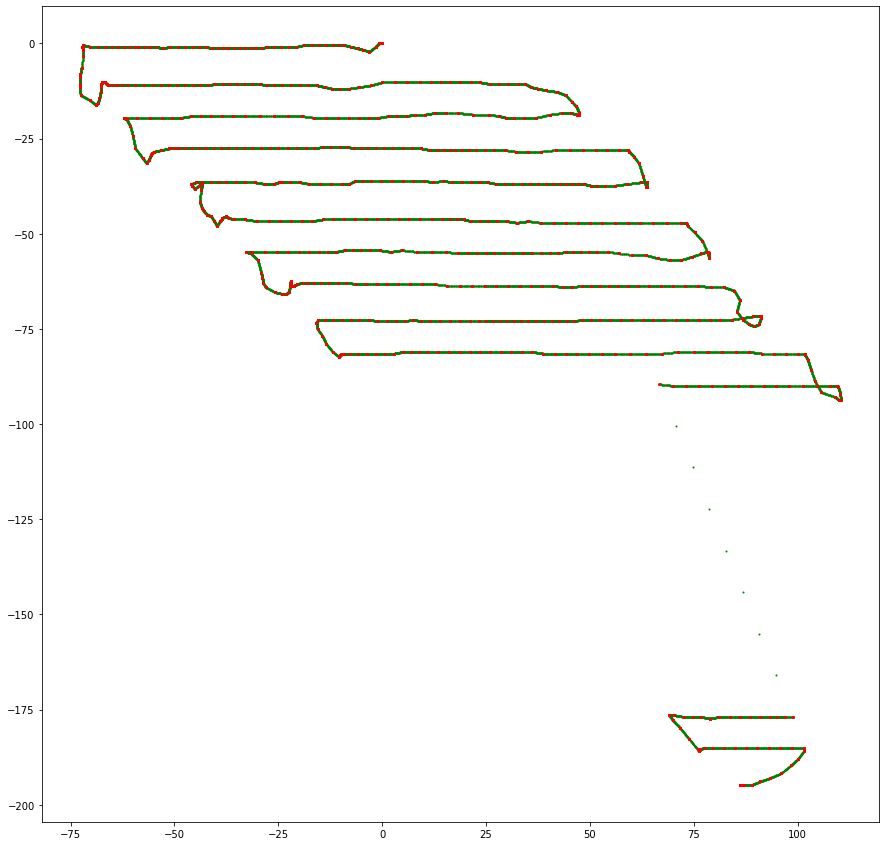

In [6]:
plt.figure(figsize=(15,15))
plt.scatter(gps_interp[:, 0], gps_interp[:, 1], s=1, c="g")
plt.scatter(gps[:, 0], gps[:, 1], s=1, c="r")

### Select subset of frames based on travelled GPS distance

In [7]:
threshold = 0.5  # m
last_pos = np.zeros((2,))
selected_frames = [0]
for i in range(len(gps)):
    pos = gps[i, :2]
    #print(np.linalg.norm(pos - last_pos))
    if np.linalg.norm(pos - last_pos) > threshold:
        last_pos = pos
        selected_frames.append(i)
        
print(len(selected_frames))

624


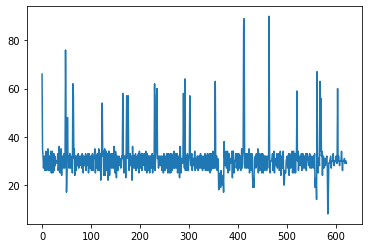

In [12]:
plt.plot(np.diff(selected_frames))

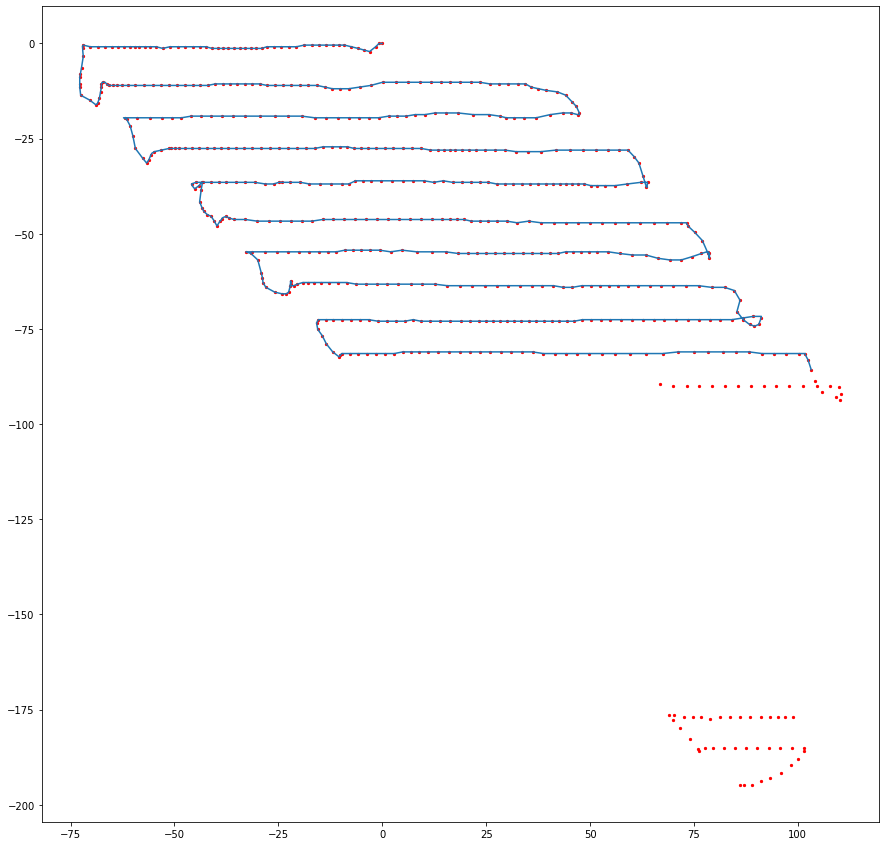

In [19]:
plt.figure(figsize=(15,15))
plt.plot(gps[:17500, 0], gps[:17500, 1])
plt.scatter(gps[selected_frames, 0], gps[selected_frames, 1], c="r", s=5)
plt.show()

In [20]:
# get corresponding video frames
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
dist_coeffs = pickle.load(open("../camera_calibration/parameters/ir/dist_coeffs.pkl", "rb"))

frames_root = "../data_processing/splitted"
frame_files = sorted(glob.glob(os.path.join(frames_root, "radiometric", "*.tiff")))
frame_files = frame_files[:17500]
cap = Capture(frame_files, None, camera_matrix, dist_coeffs)

In [22]:
# write output video from selected frames for debugging
video_shape = (640, 512)
video_fps = 1
video_path = "selected_frames.avi"
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
videowriter = cv2.VideoWriter(video_path, fourcc, video_fps, video_shape)

for i, selected_frame in enumerate(selected_frames):
    frame, _, frame_name, _ = cap.get_frame(selected_frame, preprocess=True, undistort=True, equalize_hist=True)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    videowriter.write(frame)
    cv2.imwrite(os.path.join("selected_frames", "frame_{:06d}.jpg".format(i)), frame)
    
videowriter.release()

error: OpenCV(4.5.3) /tmp/pip-req-build-tjxnaiom/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
# compute a better GPS trajectory containing a z-signal also

In [ ]:
# extract features
# find feature tracks
#   a) for temporally adjacent frames
#   b) for spatially adjacent frames (based on GPS position)

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb = cv2.ORB_create(nfeatures=5000, fastThreshold=12, scaleFactor=8, nlevels=1.2)
match_max_distance = 20.0

In [ ]:
# initialize map points from feature tracks (choose pair with widest baseline for triangulation)
# bundle adjustment